In [51]:
!python -m pip install --user -q -r ../requirements.txt

# Gradienter
Mot slutten av `tensor.ipynb` i del 1 så vi at tensorer ikke er som helt vanlige flerdimensjonale Python lister. Vi kan nemlig spesifisere hvilken GPU de skal ligge på.  
En annen viktig funksjonalitet som PyTorch tilbyr på denne datastrukturen er loggføring av hvilke operasjoner som utføres på tensorer, noe som er essensielt for at nevrale nettverk skal kunne trenes.

In [52]:
import torch

Loggføringen skjer bare på tensorer hvor flagget `requires_grad` settes, og på tensorer som deltar i en operasjon med en annen tensor som har det aktivert. Når man initialiserer et lag fra `torch.nn` vil parameterne automatisk ha dette flagget satt.

**Merk**: Alt som gjøres i denne notebooken er for moro skyld. Det er ikke ting man gjør i praksis. Hvordan PyTorch tar i bruk loggen for å trene nevrale nettverk skjer automatisk, som vist i `models.ipynb`.
 
Vi begynner med et enkelt eksempel for å vise hvordan loggen ser ut.

In [53]:
tensor = torch.rand(2, 2, requires_grad=True)
tensor

tensor([[0.7858, 0.2016],
        [0.5659, 0.6141]], requires_grad=True)

In [54]:
tensor = tensor + 2
tensor

tensor([[2.7858, 2.2016],
        [2.5659, 2.6141]], grad_fn=<AddBackward0>)

In [55]:
tensor = tensor * 10
tensor

tensor([[27.8583, 22.0159],
        [25.6593, 26.1415]], grad_fn=<MulBackward0>)

In [56]:
tensor = tensor / 10
tensor

tensor([[2.7858, 2.2016],
        [2.5659, 2.6141]], grad_fn=<DivBackward0>)

Etter hver operasjon får den nye tensoren en `grad_fn` tilknyttet seg som beskriver historikken. Loggen som konstrueres kalles for en _computational graph_, og vi kan sjekke den for å se at operasjonene er dokumentert. 

In [57]:
grad_fn = tensor.grad_fn
while len(grad_fn.next_functions) != 0:
    print(grad_fn)
    grad_fn = grad_fn.next_functions[0][0]


## Gradient descent
For å forstå bedre hva gradienter vil si for nevrale nettverk tar vi for oss et enkelt nevralt nettverk som sett under. Vi kommer derimot ikke til å gå innpå matematikken som kreves for å _regne_ ut selve gradientene (metoden som heter backpropagation), det lar vi fortsatt PyTorch gjøre. Hvis du er interessert i hvordann backpropagation fungerer kan du gå gjennom [denne artikkelen](http://neuralnetworksanddeeplearning.com/chap2.html).

<img src="../res/nn-simple.svg" width="500px" height="auto" alt="SVG Image"/>

Dette nevrale nettverket representerer funksjonen $y(x) = w \cdot x + b$, der $w$ er en skalar vekt og $b$ er en skalar bias. 

Vi lager en metode for å ta i bruk denne funksjonen.

In [58]:
def forward(w, b, x):
    return x @ w.T + b

w = torch.randn(1, 1, requires_grad=True) # Weights in a linear layer must have shape (n, m) where n is the number of features and m is the number of outputs
b = torch.randn(1, 1, requires_grad=True) # Biases in a linear layer must have shape (1, m) where m is the number of outputs

x = torch.tensor([[1.0]])
forward(w, b, x)

tensor([[-0.9738]], grad_fn=<AddBackward0>)

Hva som er riktige verdier på parameterne bestemmer vi selv. La oss lage et lite datasett som reflekterer $w=2$ og $b=1$

In [59]:
data = torch.Tensor([i for i in range(10)]).unsqueeze(1) # Inputs
target = data * 2 + 1 # Targets, where y = 2x + 1

Parameterne våre er tilfeldige verdier, men vi kan likevel visualisere hvor bra de er med å plotte funksjonen. Det er tydelig at den ikke passer særlig godt med fasiten.

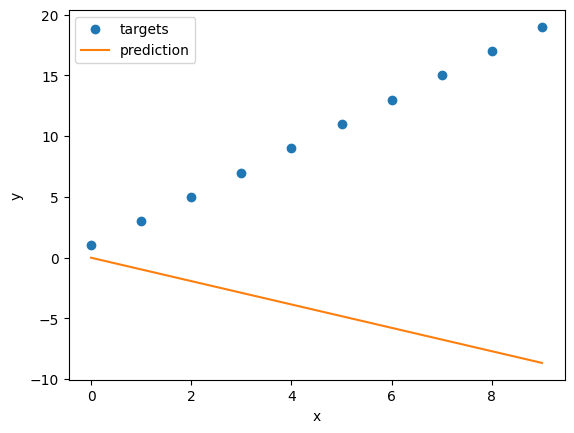

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.close()
fig, ax = plt.subplots()
ax.plot(data, target, 'o')
ax.plot(data, forward(w, b, data).detach().numpy())
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(['targets', 'prediction'])

Vi definerer så en enkel loss-funksjon

In [61]:
def loss_fn(y_pred, y):
    return ((y_pred - y)**2).mean()

No such comm: e07490cb9ca44d699d4c48f096369f0a


Et loss-landskap er en høydimensjonal flate over alle parametere, hvor _høyden_ på et punkt definerer hvor gunstige parameterne er. Siden det enkle nevrale nettverket vårt bare har to parametere, kan vi visualisere denne flaten i tre dimensjoner.

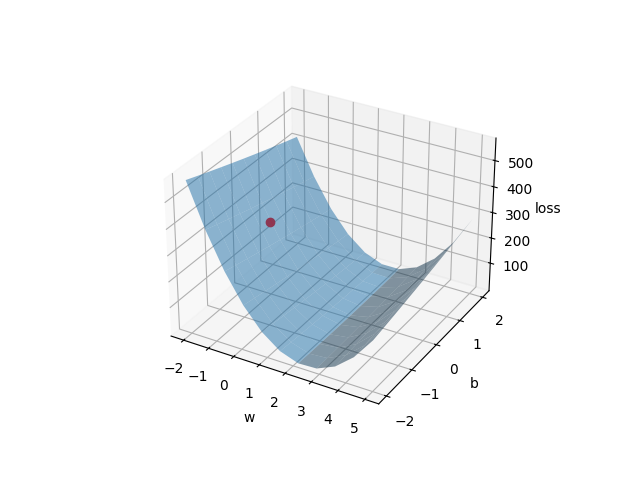

In [62]:
%matplotlib ipympl
# Create grid of loss landscape
ws = torch.linspace(-2, 5, 11)
bs = torch.linspace(-2, 2, 11)

loss_grid = torch.zeros((len(ws), len(bs)))
for i, iter_w in enumerate(ws):
    for j, iter_b in enumerate(bs):
        curr_w = iter_w[None, None, ...] # Reshape to (1, 1) to match shape of w
        curr_b = iter_b[None, None, ...] # Reshape to (1, 1) to match shape of b
        pred = forward(curr_w, curr_b, data)
        loss = loss_fn(pred, target)
        loss_grid[i, j] = loss


# surface plot
plt.close()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = torch.meshgrid(ws, bs, indexing='ij')
ax.plot_surface(X, Y, loss_grid, alpha=0.5)
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('loss')
# plot point
ax.plot(w.detach().numpy(), b.detach().numpy(), loss_fn(forward(w, b, data), target).detach().numpy(), 'ro')



Når man prater om _gradient descent_, er det denne flaten man ønsker å traversere seg nedover på. Gjør man det, vil man finne parametere hvor loss-funksjonen minimaliseres. Fra flervariabel analyse er gradienter vektorer som peker den retningen en flate stiger mest fra et punkt. Motsatt vei er den bratteste veien ned. 

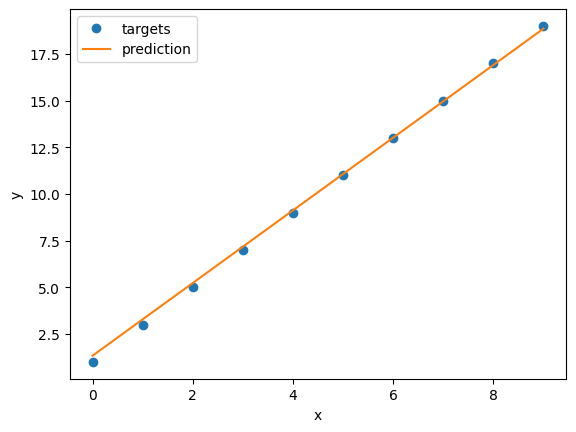

In [63]:
%matplotlib inline

w = torch.randn(1, 1, requires_grad=True)
b = torch.randn(1, 1, requires_grad=True)

num_epochs = 1000
lr = 0.001 # Learning rate

stored_params = torch.zeros((num_epochs, 2))
stored_loss = torch.zeros(num_epochs)
for epoch in range(num_epochs):
    # Forward pass
    y_pred = forward(w, b, data)
    # Compute loss
    loss = loss_fn(y_pred, target)
    # Backward pass
    loss.backward()
    # Update weights to minimize loss
    w.data -= lr * w.grad 
    b.data -= lr * b.grad

    # Store weights for plotting later
    stored_params[epoch, :] = torch.tensor([w.data, b.data]).squeeze()
    stored_loss[epoch] = loss
    
    # Zero gradients
    w.grad.zero_()
    b.grad.zero_()

# Remove current plot
plt.close()
plt.close()
fig, ax = plt.subplots()
ax.plot(data, target, 'o')
ax.plot(data, forward(w, b, data).detach().numpy())
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(['targets', 'prediction'])


Vi har lagret parameterne og lossene som ble regnet ut iløpet av treningen. Vi kan plotte disse oppå loss-landskapet. 

No such comm: 63ddf751d2324d5fab257dd68295ddd7


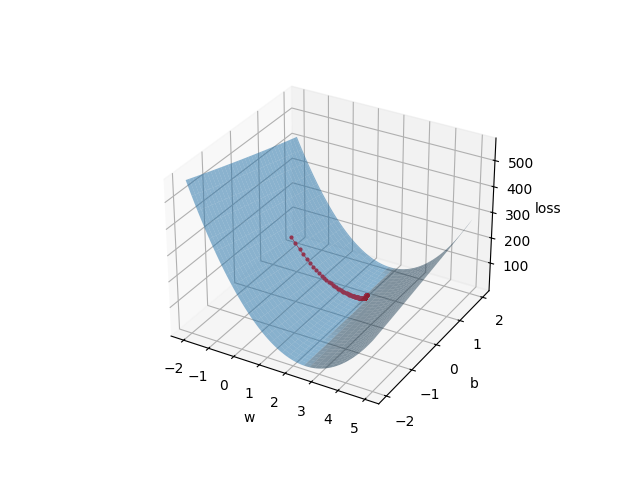

No such comm: 52de5ff5c8fe42efa427557b6015f43e


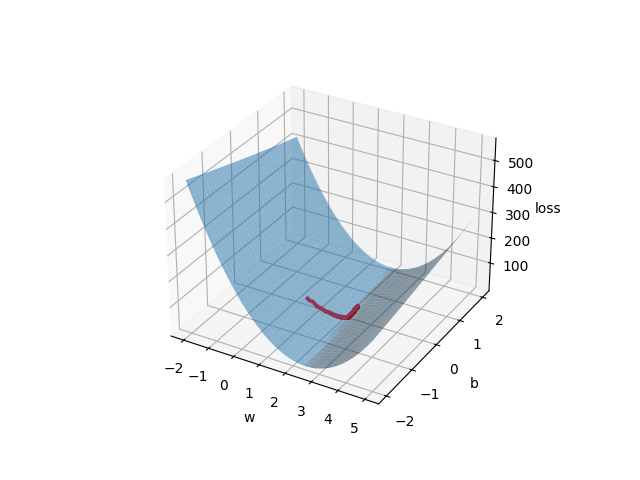

No such comm: 3e3250740ae344c5aaeb90842ec114d2


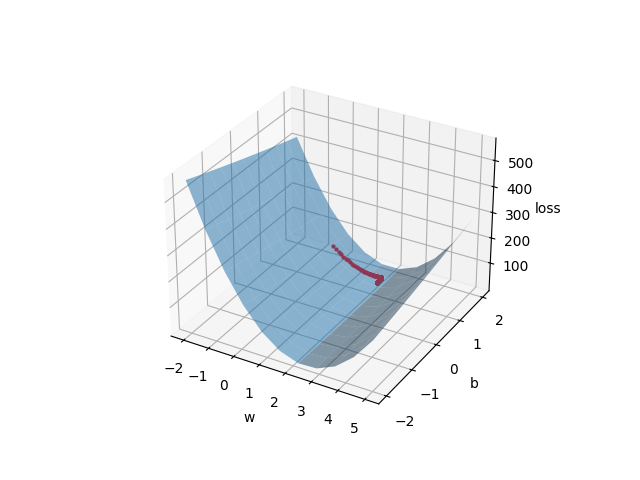

In [64]:
%matplotlib ipympl
plt.close(fig)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = torch.meshgrid(ws, bs, indexing='ij')
ax.plot_surface(X, Y, loss_grid, alpha=0.5)
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('loss')
# plot stored points
ax.plot(stored_params[:, 0], stored_params[:, 1], stored_loss.data, 'ro-', markersize=2, linewidth=0.5)